# HISTOGRAM OF ORIENTED GRADIENTS

# 1) What is a feature descriptor?

A feature descriptor is basically a representation of an image or an image patch that is obtained by extracting useful information and throwing away extraneous information. It's is an algorithm which takes an image and outputs feature descriptors/feature vectors.


## 1.1 - Edge Detection

![edge](Elements/jup1.jpeg)

## 1.2 - Corner Detection

![corner](Elements/jup2.png)

## 1.3 - How does a feature descriptor work?

Feature descriptors encode interesting information into a series of numbers and act as a sort of numerical "fingerprint" that can be used to differentiate one feature from another. Ideally this information would be invariant under image transformation, so we can find the feature again even if the image is transformed in some way. 

The intent of a feature descriptor is to generalize the object in such a way that the same object (in this case a person) produces as close as possible to the same feature descriptor when viewed under different conditions. This makes the classification and recognition of objects in images more robust. 

# 2) HoG as a feature descriptor

Typically, a feature descriptor converts an image of size width x height x 3 (channels ) to a feature vector / array of length n.
HoG uses a “global” feature to describe a person(in general, an object) rather than a collection of “local” features. Put simply, this means that the entire person is represented by a single feature vector, as opposed to many feature vectors representing smaller parts of the person.

## 2.1 - Features used in HoG

Here, the distribution ( histograms ) of directions of gradients ( oriented gradients ) are used as features. Gradients ( x and y derivatives ) of an image are used because the magnitude of gradients is large around edges and corners ( regions of abrupt intensity changes ) and as such edges and corners pack in a lot more information about object shape than flat regions.

# 3) Calculating Histogram of Oriented Gradients

The HOG person detector uses a detection window that is 64 pixels wide by 128 pixels tall. (The image as such may be of any size. The only constraint is that the image patch being analysed has a fixed aspect ratio of 1:2)

![patch](Elements/patch.jpg)

## 3.1 - Calculating gradient vector of each pixel

A gradient is a measure of the change in pixel values along the x-direction and the y-direction around each pixel.

Let’s say we want to compute the gradient vector at the pixel highlighted in red below.

![gradient1](Elements\grad1.png)

 Rate of change in the x direction is 94 - 56 = 38.
 Rate of change in the y direction is 93 - 55 = 38.
 
 So, magnitude of gradient vector is (38^2+38^2)^0.5 = 53.74 and angle = arctan(38/38) = 45 degrees.
 
![gradient2](Elements\grad2.png)
 
 

## 3.2 - Python gradient calculation

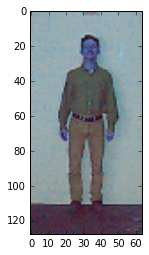

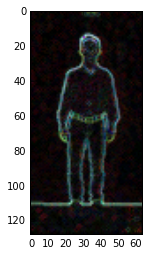

In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Read image
img = cv2.imread('Elements/person.ppm')
img = np.float32(img) / 255.0
# Calculate gradient 
gx = cv2.Sobel(img, cv2.CV_32F, 1, 0, ksize=1)
gy = cv2.Sobel(img, cv2.CV_32F, 0, 1, ksize=1)

# Python Calculate gradient magnitude and direction ( in degrees ) 
mag, angle = cv2.cartToPolar(gx, gy, angleInDegrees=True)
plt.imshow(img)
plt.show()
plt.imshow(mag)
plt.show()

The gradient image removed a lot of non-essential information ( e.g. constant colored background ), but highlighted outlines. In other words, you can look at the gradient image and still easily say there is a person in the picture.
At every pixel, the gradient has a magnitude and a direction. For color images, the gradients of the three channels are evaluated ( as shown in the figure above ). The magnitude of gradient at a pixel is the maximum of the magnitude of gradients of the three channels, and the angle is the angle corresponding to the maximum gradient.

## 3.3 - Normalising the gradient

By normalizing your gradient vectors, you can make them invariant to multiplications of the pixel values.

Modifying Images : 

![gradient3](Elements\grad3.png)



Calculating gradient vectors : 

![gradient4](Elements\grad4.png)



The gradient vectors are equivalent in the first and second images, but in the third, the gradient vector magnitude has increased by a factor of 1.5.

If you divide all three vectors by their respective magnitudes, you get the same result for all three vectors: [ 0.71  0.71]’.

So in the above example we see that by dividing the gradient vectors by their magnitude we can make them invariant (or at least more robust) to changes in contrast.

## 3.4 - Calculate Histogram of Gradients in 8×8 cells

First of all,why an 8x8 cell? 
Individual graidents may have noise, but a histogram over 8×8 patch makes the representation much less sensitive to noise.

Once the individual gradients are calculated, they have to be normalized to nullify the effects of illumination.

Rather than normalize each histogram individually, the cells are first grouped into blocks and normalized based on all histograms in the block.

The block consists of 4 cells (2 cells by 2 cells), i.e. a 16x16 block.

A 16×16 block has 4 histograms which can be concatenated to form a 36 x 1 element vector and it can be normalized just the way a 3×1 vector is normalized. The window is then moved by 8 pixels ( refer gif below ) and a normalized 36×1 vector is calculated over this window and the process is repeated.

![gradient5](Elements/grad5.gif)

The histogram is essentially a vector ( or an array ) of 9 bins ( numbers ) corresponding to angles 0, 20, 40, 60 … 160.

Let us look at one 8×8 patch in the image and see how the gradients look.

![gradient6](Elements/grad6.png)

The next step is to create a histogram of gradients in these 8×8 cells. The histogram contains 9 bins corresponding to angles 0, 20, 40 … 160.

The following figure illustrates the process. We are looking at magnitude and direction of the gradient of the same 8×8 patch as in the previous figure. A bin is selected based on the direction, and the vote ( the value that goes into the bin ) is selected based on the magnitude. Let’s first focus on the pixel encircled in blue. It has an angle ( direction ) of 80 degrees and magnitude of 2. So it adds 2 to the 5th bin. The gradient at the pixel encircled using red has an angle of 10 degrees and magnitude of 4. Since 10 degrees is half way between 0 and 20, the vote by the pixel splits evenly into the two bins.

![gradient7](Elements/grad7.png)

Once gradients are obtained from four 8x8 cells, they are normalized over the 16x16 block. A normalised 36x1 feature vector is calculated. Now the window moves by 8 pixels and the process continues.

## 3.5 - Calculating the final feature vector

All the 36x1 vectors calculated are concatenated into one giant vector.


1.How many positions of the 16×16 blocks do we have ? There are 7 horizontal and 15 vertical positions making a total of   7 x 15 = 105 positions.

2.Each 16×16 block is represented by a 36×1 vector. So when we concatenate them all into one gaint vector we obtain a 36×105 = 3780 dimensional vector.


# 4) Visualising HoG features

Generally, the HOG descriptor of an image is visualized by plotting the 9×1 normalized histograms in the 8×8 cells. Refer to the image below. You will notice that dominant direction of the histogram captures the shape of the person, especially around the torso and legs.

![hog2](Elements/hog2.png)

![hog1](Elements/hog1.png)

# 5) Using HoG features to detect pedastrians

In [2]:
import os
import glob

### 5.1 - Initialize Global Variables

In [3]:
params={}
params["img_path"] =os.path.join("Elements","hog_images")

### 5.2 - Extract all images

In [4]:
list_of_images = glob.glob(os.path.join(params["img_path"],'*'))
print(list_of_images)

['Elements/hog_images/Pedestrians.jpg', 'Elements/hog_images/family-crossing.jpg', 'Elements/hog_images/Montague-pedestrians.png', 'Elements/hog_images/140523-pedestrian-florida-miami-mms-1515_85f83b5a747c362e6b2334a1f0e0326f.nbcnews-ux-2880-1000.jpg']


### 5.3 - Initialize HOG descriptor

In [5]:
hog = cv2.HOGDescriptor()
hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())#using inbuilt HoG descriptor for people

(1200, 1600, 3) 4.0


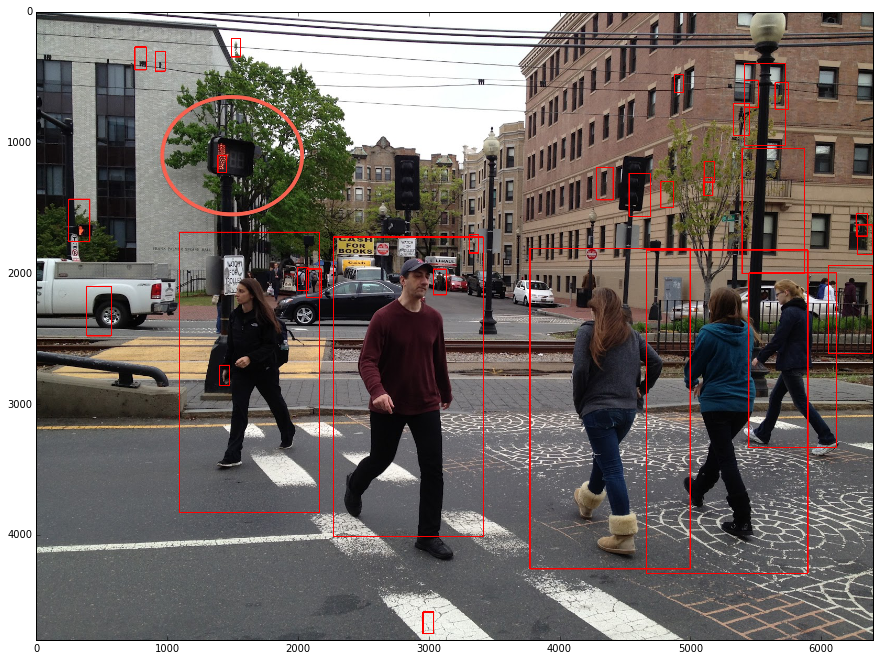

(300, 490, 3) 1.225


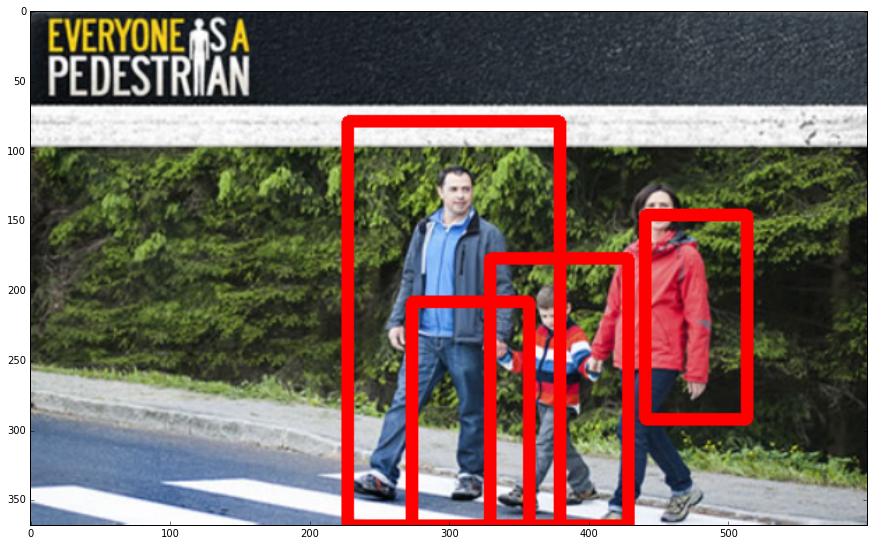

(960, 1280, 3) 3.2


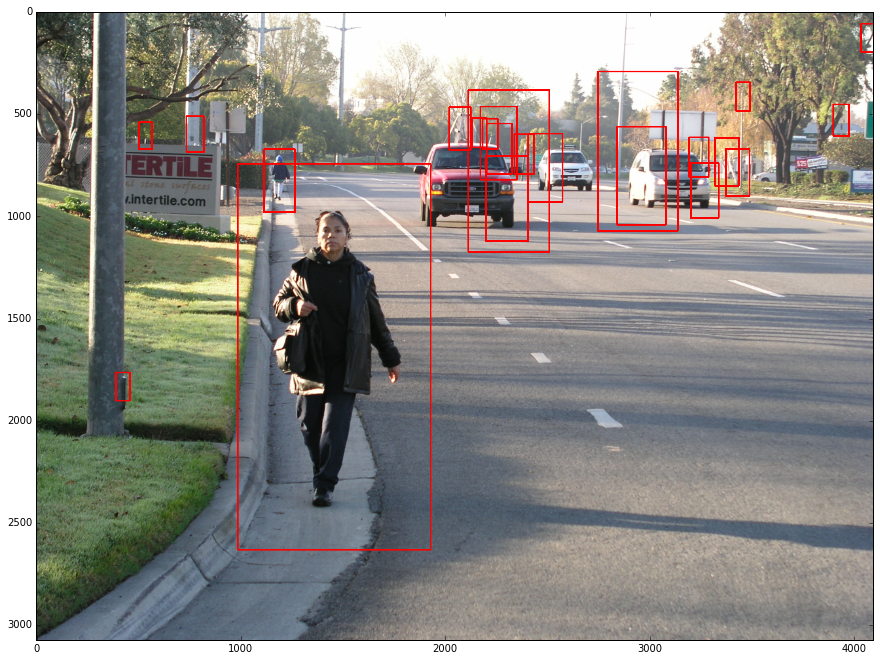

(1000, 1588, 3) 3.97


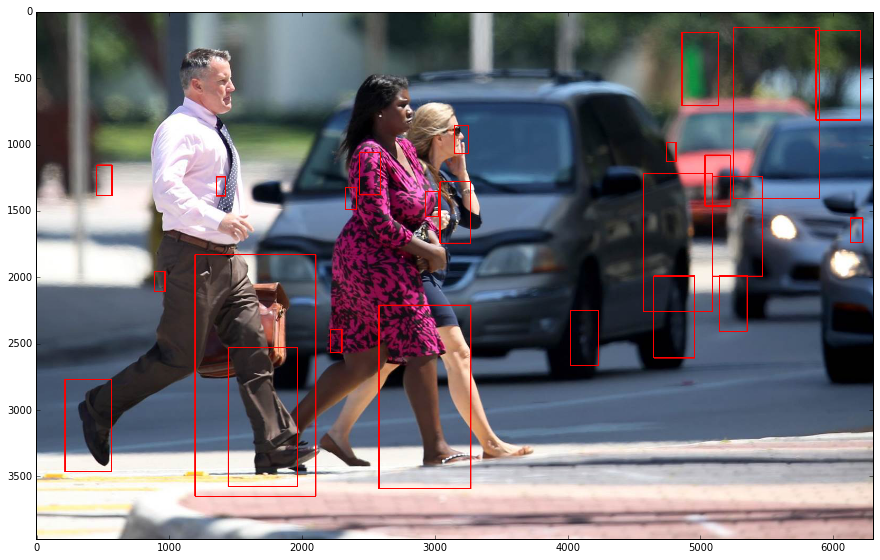

In [6]:
for imagePath in list_of_images:
    # load the image and resize it to (1) reduce detection time
    # and (2) improve detection accuracy
    image = cv2.imread(imagePath)
    image_fx = image.shape[1] / min(400, image.shape[1])
    print(image.shape, image_fx)
    image = cv2.resize(image, (0,0), fx=image_fx, fy=image_fx)
    orig = image.copy()
 
    # detect people in the image
    (rects, weights) = hog.detectMultiScale(image, winStride=(4, 4),
        padding=(8, 8), scale=1.05)
 
    # draw the original bounding boxes
    for (x, y, w, h) in rects:
        cv2.rectangle(orig, (x, y), (x + w, y + h), (0, 0, 255), 8)
    
    plt.figure(figsize=(15,15))
    plt.imshow(orig[:,:,::-1])
    plt.show()

### 5.4 - Results
Well, it's detecting stuff, but a lot of false positives are there too

## 6) Next Challenge

Apply Non-maximal suppression to remove the nested false detections at least. This is a task for you guys to do. Do NOT use pyimagesearch dude's already existing implentation, try doing it yourself